![](https://www.pata.org/wp-content/uploads/2014/09/TripAdvisor_Logo-300x119.png)
# Predict TripAdvisor Rating
## В этом соревновании нам предстоит предсказать рейтинг ресторана в TripAdvisor
**По ходу задачи:**
* Прокачаем работу с pandas
* Научимся работать с Kaggle Notebooks
* Поймем как делать предобработку различных данных
* Научимся работать с пропущенными данными (Nan)
* Познакомимся с различными видами кодирования признаков
* Немного попробуем [Feature Engineering](https://ru.wikipedia.org/wiki/Конструирование_признаков) (генерировать новые признаки)
* И совсем немного затронем ML
* И многое другое...   



### И самое важное, все это вы сможете сделать самостоятельно!

*Этот Ноутбук являетсся Примером/Шаблоном к этому соревнованию (Baseline) и не служит готовым решением!*   
Вы можете использовать его как основу для построения своего решения.

> что такое baseline решение, зачем оно нужно и почему предоставлять baseline к соревнованию стало важным стандартом на kaggle и других площадках.   
**baseline** создается больше как шаблон, где можно посмотреть как происходит обращение с входящими данными и что нужно получить на выходе. При этом МЛ начинка может быть достаточно простой, просто для примера. Это помогает быстрее приступить к самому МЛ, а не тратить ценное время на чисто инженерные задачи. 
Также baseline являеться хорошей опорной точкой по метрике. Если твое решение хуже baseline - ты явно делаешь что-то не то и стоит попробовать другой путь) 

В контексте нашего соревнования baseline идет с небольшими примерами того, что можно делать с данными, и с инструкцией, что делать дальше, чтобы улучшить результат.  Вообще готовым решением это сложно назвать, так как используются всего 2 самых простых признака (а остальные исключаются).

# import

In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 
import matplotlib.pyplot as plt
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import re
import seaborn as sns
%matplotlib inline

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Функция подсчета значений в столбце, содержащим данные с разделителем
def sep_counter(dataset, column, sep=','):
    ds = dataset[column].str.cat(sep=sep)
    data_split = pd.Series(ds.split(sep))
    info = data_split.value_counts(ascending=False)

    return info


from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Получить список топовых слов
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer(stop_words=stopwords.words('english')).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)

    return words_freq[:n]


# Создать фичи из слов
def create_top_word_feature(comment):
    vec = CountVectorizer(stop_words=stopwords.words('english')).fit(comment)
    bag_of_words = vec.transform(comment)

    for key in vec.vocabulary_.keys():
        if key in top_word_list:
            return 1
        else:
            return 0

# Округляем ценку с шагом 0.5
def norm_rank(rank):
    return (np.round(rank * 2.0) / 2)


# Анализ тональности отзыва
def sentiment_analysis(text):
    from nltk.sentiment.vader import SentimentIntensityAnalyzer

    sid = SentimentIntensityAnalyzer()
    pos_word_list = []
    neu_word_list = []
    neg_word_list = []

    for word in text:
        if (sid.polarity_scores(word)['compound']) >= 0.5:
            pos_word_list.append(word)
        elif (sid.polarity_scores(word)['compound']) <= -0.5:
            neg_word_list.append(word)
        else:
            neu_word_list.append(word)

    # pos, neutral, neg
    return len(pos_word_list), len(neu_word_list), len(neg_word_list)


# Получаем бинарные признаки из признака, содержащего списки
def get_binary_dummies(data, column):
    from sklearn.preprocessing import MultiLabelBinarizer

    # Бинарные метки
    mlb = MultiLabelBinarizer()
    expandedLabelData = mlb.fit_transform(data[column])
    labelClasses = mlb.classes_

    # Создаем датафрэйм бинарных признаков
    expandedLabels = pd.DataFrame(expandedLabelData, columns=labelClasses)

    return expandedLabels


In [4]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [5]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
#!pip freeze > requirements.txt

# DATA

In [6]:
df_train = pd.read_csv('main_task.csv')
df_test = pd.read_csv('kaggle_task.csv')
sample_submission = pd.read_csv('sample_submission.csv')

In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
Restaurant_id        40000 non-null object
City                 40000 non-null object
Cuisine Style        30717 non-null object
Ranking              40000 non-null float64
Rating               40000 non-null float64
Price Range          26114 non-null object
Number of Reviews    37457 non-null float64
Reviews              40000 non-null object
URL_TA               40000 non-null object
ID_TA                40000 non-null object
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


In [8]:
df_train.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781
3,id_3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963


In [9]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
Restaurant_id        10000 non-null object
City                 10000 non-null object
Cuisine Style        7693 non-null object
Ranking              10000 non-null float64
Price Range          6525 non-null object
Number of Reviews    9343 non-null float64
Reviews              9998 non-null object
URL_TA               10000 non-null object
ID_TA                10000 non-null object
dtypes: float64(2), object(7)
memory usage: 703.2+ KB


In [10]:
df_test.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354


In [11]:
sample_submission.head(5)

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0


In [12]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
Restaurant_id    10000 non-null object
Rating           10000 non-null float64
dtypes: float64(1), object(1)
memory usage: 156.3+ KB


In [13]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
Restaurant_id        50000 non-null object
City                 50000 non-null object
Cuisine Style        38410 non-null object
Ranking              50000 non-null float64
Price Range          32639 non-null object
Number of Reviews    46800 non-null float64
Reviews              49998 non-null object
URL_TA               50000 non-null object
ID_TA                50000 non-null object
sample               50000 non-null int64
Rating               50000 non-null float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


Подробнее по признакам:
* City: Город 
* Cuisine Style: Кухня
* Ranking: Ранг ресторана относительно других ресторанов в этом городе
* Price Range: Цены в ресторане в 3 категориях
* Number of Reviews: Количество отзывов
* Reviews: 2 последних отзыва и даты этих отзывов
* URL_TA: страница ресторана на 'www.tripadvisor.com' 
* ID_TA: ID ресторана в TripAdvisor
* Rating: Рейтинг ресторана

In [15]:
data.sample(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating
25692,id_2095,Stockholm,"['Japanese', 'Sushi']",2098.0,$$ - $$$,21.0,[['Has improved but there is better Sushi aro....,/Restaurant_Review-g189852-d809897-Reviews-IKK...,d809897,1,3.0
23232,id_1059,Brussels,"['Filipino', 'Asian']",1060.0,$$ - $$$,23.0,"[['Definitely worth a visit', '5-star review w...",/Restaurant_Review-g950780-d10182283-Reviews-B...,d10182283,1,4.5
33434,id_10932,London,"['Asian', 'Malaysian', 'Vegetarian Friendly', ...",10942.0,$$ - $$$,324.0,"[['Average at Best', 'Saturday lunch'], ['12/1...",/Restaurant_Review-g186338-d3752919-Reviews-Pe...,d3752919,1,3.5
16376,id_556,Budapest,"['Bar', 'European', 'British', 'Pub', 'Scottish']",557.0,$$ - $$$,169.0,"[['Good bar', 'halloween'], ['11/28/2017', '11...",/Restaurant_Review-g274887-d2408752-Reviews-Ca...,d2408752,1,4.5
27031,id_1618,Milan,"['Italian', 'Seafood', 'Vegetarian Friendly']",1620.0,$$ - $$$,132.0,"[['very nice hidden taverna with delicious ""p....",/Restaurant_Review-g187849-d8014818-Reviews-Os...,d8014818,1,4.0


In [16]:
data.Reviews[1]

"[['Very good reviews!', 'Fine dining in Hakaniemi'], ['12/05/2017', '10/29/2017']]"

Как видим, большинство признаков у нас требует очистки и предварительной обработки.

# Cleaning and Prepping Data
Обычно данные содержат в себе кучу мусора, который необходимо почистить, для того чтобы привести их в приемлемый формат. Чистка данных — это необходимый этап решения почти любой реальной задачи.   
![](https://analyticsindiamag.com/wp-content/uploads/2018/01/data-cleaning.png)

## 1. Обработка NAN 
У наличия пропусков могут быть разные причины, но пропуски нужно либо заполнить, либо исключить из набора полностью. Но с пропусками нужно быть внимательным, **даже отсутствие информации может быть важным признаком!**   
По этому перед обработкой NAN лучше вынести информацию о наличии пропуска как отдельный признак 

In [17]:
# Для примера я возьму столбец Number of Reviews
data['Number_of_Reviews_isNAN'] = pd.isna(data['Number of Reviews']).astype('uint8')

In [18]:
data['Number_of_Reviews_isNAN']

0        0
1        0
2        0
3        0
4        0
5        0
6        0
7        1
8        0
9        0
10       0
11       0
12       0
13       0
14       0
15       0
16       0
17       0
18       0
19       0
20       0
21       0
22       0
23       0
24       0
25       1
26       0
27       0
28       0
29       0
        ..
49970    0
49971    0
49972    1
49973    0
49974    0
49975    0
49976    0
49977    0
49978    0
49979    0
49980    0
49981    0
49982    0
49983    0
49984    0
49985    0
49986    1
49987    0
49988    1
49989    1
49990    0
49991    0
49992    0
49993    0
49994    0
49995    0
49996    0
49997    0
49998    0
49999    0
Name: Number_of_Reviews_isNAN, Length: 50000, dtype: uint8

In [19]:
# Далее заполняем пропуски 0, вы можете попробовать заполнением средним или средним по городу и тд...
data['Number of Reviews'].fillna(data['Number of Reviews'].mean(), inplace=True)

### 2. Обработка признаков
Для начала посмотрим какие признаки у нас могут быть категориальными.

In [20]:
data.nunique(dropna=False)

Restaurant_id              13094
City                          31
Cuisine Style              10732
Ranking                    12975
Price Range                    4
Number of Reviews           1574
Reviews                    41858
URL_TA                     49963
ID_TA                      49963
sample                         2
Rating                        10
Number_of_Reviews_isNAN        2
dtype: int64

**Категориальными** признаками здесь являются **City** и **Cuisine Style**.

Для кодирования категориальных признаков есть множество подходов:
* Label Encoding
* One-Hot Encoding
* Target Encoding
* Hashing

Выбор кодирования зависит от признака и выбраной модели.
Не будем сейчас сильно погружаться в эту тематику, давайте посмотрим лучше пример с One-Hot Encoding:
![](https://i.imgur.com/mtimFxh.png)

In [21]:
# Сохраним оригинальный столбец City для дальнейшей обработки
data['City_Orig'] = data['City']

# для One-Hot Encoding в pandas есть готовая функция - get_dummies. Особенно радует параметр dummy_na
data = pd.get_dummies(data, columns=[ 'City',], dummy_na=True)

In [22]:
data.head(5)

,Restaurant_id,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,...,City_Oporto,City_Oslo,City_Paris,City_Prague,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich,City_nan
0,id_0,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0,...,0,0,1,0,0,0,0,0,0,0
1,id_1,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,id_2,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,id_3,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,id_4,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [23]:
data.sample(5)

,Restaurant_id,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,...,City_Oporto,City_Oslo,City_Paris,City_Prague,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich,City_nan
36138,id_1215,"['Bar', 'Pub']",1220.0,NaN,4.000000,"[['Libations at Liquid - hit or miss', 'You ma...",/Restaurant_Review-g188113-d7294511-Reviews-Li...,d7294511,1,4.5,...,0,0,0,0,0,0,0,0,1,0
47777,id_1750,NaN,1753.0,NaN,7.000000,"[['something for meat lovers', 'Heaven for lun...",/Restaurant_Review-g274707-d10878602-Reviews-P...,d10878602,1,4.5,...,0,0,0,1,0,0,0,0,0,0
14372,id_8261,['Wine Bar'],8262.0,NaN,124.471197,"[[], []]",/Restaurant_Review-g187147-d8873363-Reviews-Ch...,d8873363,1,5.0,...,0,0,1,0,0,0,0,0,0,0
604,id_604,"['American', 'Bar', 'European', 'Central Europ...",52.0,$$ - $$$,478.000000,"[['Solid place in Zurich', 'Cool place'], ['12...",/Restaurant_Review-g188113-d4363779-Reviews-LO...,d4363779,0,0.0,...,0,0,0,0,0,0,0,0,1,0
32807,id_1995,"['Asian', 'Thai']",1996.0,$$ - $$$,6.000000,"[['What an excellent find', 'Pop in Lunch'], [...",/Restaurant_Review-g188644-d13277820-Reviews-M...,d13277820,1,4.0,...,0,0,0,0,0,0,0,0,0,0


#### Возьмем следующий признак "Price Range".

In [24]:
data['Price Range'].value_counts()

$$ - $$$    23041
$            7816
$$$$         1782
Name: Price Range, dtype: int64

По описанию 'Price Range' это - Цены в ресторане.  
Их можно поставить по возрастанию (значит это не категориальный признак). А это значит, что их можно заменить последовательными числами, например 1,2,3  
*Попробуйте сделать обработку этого признака уже самостоятельно!*

In [25]:
# Ваша обработка 'Price Range'
price_range = {'$': 50, '$$ - $$$': 100, '$$$$': 150}

# Создадим признак пропусков
data['Price Range_isNaN'] = pd.isna(data['Price Range']).astype('uint8')

# Заполним пропуски самым частым значением
data['Price Range'] = data['Price Range'].fillna('$$ - $$$')

# Закодируем Price Range через LabelEncoding
data['Price Range'] = data['Price Range'].replace(price_range)


> Для некоторых алгоритмов МЛ даже для не категориальных признаков можно применить One-Hot Encoding, и это может улучшить качество модели. Пробуйте разные подходы к кодированию признака - никто не знает заранее, что может взлететь.

### Обработать другие признаки вы должны самостоятельно!
Для обработки других признаков вам возможно придется даже написать свою функцию, а может даже и не одну, но в этом и есть ваша практика в этом модуле!     
Следуя подсказкам в модуле вы сможете более подробно узнать, как сделать эти приобразования.

### Обрабатываем Reviews

In [26]:
print(data['Reviews'].sample())

# Пустой отзыв
empty_review = {'[[], []]': "[['None', 'None'], ['05/20/2000', '05/20/2000']]"}

# Создадим NaN признак
data['Reviews_is_NaN'] = pd.isna(data['Reviews']).astype('uint8')

# Заменим пустые отзывы
data['Reviews'] = data['Reviews'].replace(empty_review)

# Заполним пропуски
data['Reviews'] = data['Reviews'].fillna("[['None', 'None'], ['05/20/2000', '05/20/2000']]")

18298    [['Great value and Tasty pizza!', 'OK pizza an...
Name: Reviews, dtype: object


In [27]:
from ast import literal_eval

# Переведем отзывы в список
def get_review_lastdate(reviews):
    reviews_dates = literal_eval(reviews)[1]
    
    return reviews_dates[0]

def get_review_prelastdate(reviews):
    reviews_dates = literal_eval(reviews)[1]
    
    if len(reviews_dates) > 1:
        return reviews_dates[1]
    else: 
        return reviews_dates[0]
    

def get_review_lastcomment(reviews):
    
    reviews_text = literal_eval(reviews)[0]
    
    return reviews_text[0]  


def get_review_prelastcomment(reviews):
    reviews_text = literal_eval(reviews)[0]
    
    if len(reviews_text) > 1:
        return reviews_text[1]
    else:
        return reviews_text[0]


In [28]:
# В отзывах есть запись с NaN нужно ее поправить
data.loc[data['Reviews'].str.contains(', nan'), 'Reviews'] = "[['Will certainly be back', 'None'], ['11/26/2017', '07/27/2017']]"
data.loc[data['Reviews'].str.contains('nan, '), 'Reviews'] = "[['None', 'Good food with decent service'], ['11/21/2017', '07/21/2017']]"

In [29]:
# Создаем признаки из Review
# Последний отзыв
data['last_comment'] = data['Reviews'].apply(get_review_lastcomment)
# Предпоследний отзыв
data['prelast_comment'] = data['Reviews'].apply(get_review_prelastcomment)
# Дата последнего отзыва
data['last_comment_date'] = data['Reviews'].apply(get_review_lastdate)
# Дата предпоследнего отзыва
data['prelast_comment_date'] = data['Reviews'].apply(get_review_prelastdate)

# Переведем даты в datetime
data['last_comment_date'] = pd.to_datetime(data['last_comment_date'])
data['prelast_comment_date'] = pd.to_datetime(data['prelast_comment_date'])

# Разница в днях между отзывами
data['days_between_reviews'] = abs((data['last_comment_date'] - data['prelast_comment_date']).dt.days)

# Разница текущей даты с последним отзывом
data['days_between_today_and_lastreview'] = (pd.to_datetime('today') - data['last_comment_date']).dt.days


In [31]:
data.head()

,Restaurant_id,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,...,City_Zurich,City_nan,Price Range_isNaN,Reviews_is_NaN,last_comment,prelast_comment,last_comment_date,prelast_comment_date,days_between_reviews,days_between_today_and_lastreview
0,id_0,"['Bar', 'Pub']",12963.0,100,4.0,"[['None', 'None'], ['05/20/2000', '05/20/2000']]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0,...,0,0,0,0,None,None,2000-05-20,2000-05-20,0,7397
1,id_1,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,100,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0.0,...,0,0,0,0,Very good reviews!,Fine dining in Hakaniemi,2017-12-05,2017-10-29,37,989
2,id_2,['Vegetarian Friendly'],810.0,100,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,0.0,...,0,0,0,0,Better than the Links,Ivy Black,2017-12-28,2017-12-06,22,966
3,id_3,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,150,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,0.0,...,0,0,0,0,Most exquisite,Delicious and authentic,2017-12-06,2017-11-22,14,988
4,id_4,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,150,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,0.0,...,0,0,0,0,Always the best in bratislava,Very good but pricey,2018-02-08,2018-01-24,15,924


In [32]:
# Предобработка отзывов
def review_preprocessing2(review):       
    stop_words = stopwords.words('english')
    lemmatizer = WordNetLemmatizer()
    
    review = re.sub(re.compile('<.*?>'), '', review)
    review = re.sub('[^A-Za-z]+', ' ', review)
    
    review = review.lower()
    
    # Токенизация
    tokens = word_tokenize(review)
    
    # Удаляем стоп-слова
    review = [word for word in tokens if word not in stop_words]
    
    # Лемматизация
    review = [lemmatizer.lemmatize(word) for word in review]
    
    #review = ' '.join(review)
    
    return review

# Комментарий
data['cat_comments'] = data['last_comment'] + ' ' + data['prelast_comment']
data['comments'] = data['cat_comments'].apply(lambda review: review_preprocessing2(review))


In [33]:
data.head()

,Restaurant_id,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,...,Price Range_isNaN,Reviews_is_NaN,last_comment,prelast_comment,last_comment_date,prelast_comment_date,days_between_reviews,days_between_today_and_lastreview,cat_comments,comments
0,id_0,"['Bar', 'Pub']",12963.0,100,4.0,"[['None', 'None'], ['05/20/2000', '05/20/2000']]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0,...,0,0,None,None,2000-05-20,2000-05-20,0,7397,None None,"[none, none]"
1,id_1,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,100,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0.0,...,0,0,Very good reviews!,Fine dining in Hakaniemi,2017-12-05,2017-10-29,37,989,Very good reviews! Fine dining in Hakaniemi,"[good, review, fine, dining, hakaniemi]"
2,id_2,['Vegetarian Friendly'],810.0,100,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,0.0,...,0,0,Better than the Links,Ivy Black,2017-12-28,2017-12-06,22,966,Better than the Links Ivy Black,"[better, link, ivy, black]"
3,id_3,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,150,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,0.0,...,0,0,Most exquisite,Delicious and authentic,2017-12-06,2017-11-22,14,988,Most exquisite Delicious and authentic,"[exquisite, delicious, authentic]"
4,id_4,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,150,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,0.0,...,0,0,Always the best in bratislava,Very good but pricey,2018-02-08,2018-01-24,15,924,Always the best in bratislava Very good but pr...,"[always, best, bratislava, good, pricey]"


In [34]:
# Создадим бинарные признаки из слов
word_features = get_binary_dummies(data, 'comments')

In [35]:
# Отберем бинарные признаки, где количество повторений слова меньше 10
cols_to_delete = word_features.sum()
cols_to_delete = cols_to_delete[cols_to_delete < 50].keys()

In [36]:
# Удалим эти признаки
word_features = word_features.drop(cols_to_delete, axis=1)

In [37]:
word_features.head()

,absolutely,affordable,afternoon,almost,alternative,always,amazing,ambiance,ambience,american,...,work,world,worst,worth,would,wow,year,yet,yum,yummy
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [38]:
# Добавим количество положительных, нейтральных, негативных слов в отзыве
data['PNN'] = data['comments'].apply(sentiment_analysis)

In [39]:
data.head()

,Restaurant_id,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,...,Reviews_is_NaN,last_comment,prelast_comment,last_comment_date,prelast_comment_date,days_between_reviews,days_between_today_and_lastreview,cat_comments,comments,PNN
0,id_0,"['Bar', 'Pub']",12963.0,100,4.0,"[['None', 'None'], ['05/20/2000', '05/20/2000']]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0,...,0,None,None,2000-05-20,2000-05-20,0,7397,None None,"[none, none]","(0, 2, 0)"
1,id_1,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,100,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0.0,...,0,Very good reviews!,Fine dining in Hakaniemi,2017-12-05,2017-10-29,37,989,Very good reviews! Fine dining in Hakaniemi,"[good, review, fine, dining, hakaniemi]","(0, 5, 0)"
2,id_2,['Vegetarian Friendly'],810.0,100,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,0.0,...,0,Better than the Links,Ivy Black,2017-12-28,2017-12-06,22,966,Better than the Links Ivy Black,"[better, link, ivy, black]","(0, 4, 0)"
3,id_3,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,150,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,0.0,...,0,Most exquisite,Delicious and authentic,2017-12-06,2017-11-22,14,988,Most exquisite Delicious and authentic,"[exquisite, delicious, authentic]","(1, 2, 0)"
4,id_4,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,150,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,0.0,...,0,Always the best in bratislava,Very good but pricey,2018-02-08,2018-01-24,15,924,Always the best in bratislava Very good but pr...,"[always, best, bratislava, good, pricey]","(1, 4, 0)"


In [40]:
#data['PNN'].to_csv('pnn.csv')

In [41]:
# Количество позитивных слов
data['Positive Words'] = data['PNN'].apply(lambda s: s[0])
# Количество негативных слов
data['Negative Words'] = data['PNN'].apply(lambda s: s[2])
# Количество нейтральных слов
data['Neutral Words'] = data['PNN'].apply(lambda s: s[1])


In [42]:
# Положительных слов на город
cities_pos_count = data.groupby('City_Orig')['Positive Words'].sum().to_dict()
# Отрицательных слов на город
cities_neg_count = data.groupby('City_Orig')['Negative Words'].sum().to_dict()
# Нейтральных слов на город
cities_neu_count = data.groupby('City_Orig')['Neutral Words'].sum().to_dict()

data['City Positive Words'] = data['City_Orig'].apply(lambda s: cities_pos_count[s])
data['City Negative Words'] = data['City_Orig'].apply(lambda s: cities_neg_count[s])
data['City Neutral Words'] = data['City_Orig'].apply(lambda s: cities_neu_count[s])

In [43]:
data.head()

,Restaurant_id,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,...,days_between_today_and_lastreview,cat_comments,comments,PNN,Positive Words,Negative Words,Neutral Words,City Positive Words,City Negative Words,City Neutral Words
0,id_0,"['Bar', 'Pub']",12963.0,100,4.0,"[['None', 'None'], ['05/20/2000', '05/20/2000']]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0,...,7397,None None,"[none, none]","(0, 2, 0)",0,0,2,4092,217,28563
1,id_1,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,100,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0.0,...,989,Very good reviews! Fine dining in Hakaniemi,"[good, review, fine, dining, hakaniemi]","(0, 5, 0)",0,0,5,283,23,2632
2,id_2,['Vegetarian Friendly'],810.0,100,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,0.0,...,966,Better than the Links Ivy Black,"[better, link, ivy, black]","(0, 4, 0)",0,0,4,670,20,3510
3,id_3,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,150,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,0.0,...,988,Most exquisite Delicious and authentic,"[exquisite, delicious, authentic]","(1, 2, 0)",1,0,2,5754,283,36335
4,id_4,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,150,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,0.0,...,924,Always the best in bratislava Very good but pr...,"[always, best, bratislava, good, pricey]","(1, 4, 0)",1,0,4,232,19,1811


In [44]:
# Доля положительных отзывов на город
data['City Positive Percent'] = data['City Positive Words'] / (data['City Positive Words'] + data['City Negative Words'] + data['City Neutral Words'])

# Доля отрицательных отзывов на город
data['City Negative Percent'] = data['City Negative Words'] / (data['City Positive Words'] + data['City Negative Words'] + data['City Neutral Words'])

# Доля нейтральных слов
data['City Neutral Percent'] = data['City Neutral Words'] / (data['City Positive Words'] + data['City Negative Words'] + data['City Neutral Words'])


In [45]:
# Среднее количество отзывов на город
mean_reviews = data.groupby('City_Orig')['Number of Reviews'].mean().to_dict()
data['Mean Number of Reviews'] = data['City_Orig'].apply(lambda s: mean_reviews[s])

In [46]:
# Средний чек на город
#mean_price_range = data.groupby('City_Orig')['Price Range'].mean().to_dict()
#data['Mean Price Range'] = data['City_Orig'].apply(lambda s: mean_price_range[s])
#mean_price_range

In [47]:
# Обрабатываем Cuisine Style
data['Cuisine Style'].isna().sum()

# Создадим NaN признак
data['Cuisine Style_is_NaN'] = pd.isna(data['Cuisine Style']).astype('uint8')


In [48]:
# Заполним пропуски Cuisine Style значением Local (местная)
data['Cuisine Style'] = data['Cuisine Style'].fillna("['Local']")
# Средний ранк ресторана в городе
#data['Cuisine Style'].groupby('City_Orig')['Cuisine Style'].mode()

In [49]:
# Посмотрим на данные в Cuisine Style
data['Cuisine Style'].sample()

36044    ['Local']
Name: Cuisine Style, dtype: object

In [50]:
# Почистим Cuisine Style
#data['Cuisine Style'] = data['Cuisine Style'].apply(lambda s: s.replace('[', '').replace(']', '').replace(', ', ',') if not pd.isnull(s) else s)
data['Cuisine Style'] = data['Cuisine Style'].apply(literal_eval)


In [51]:
data.head()

,Restaurant_id,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,...,Negative Words,Neutral Words,City Positive Words,City Negative Words,City Neutral Words,City Positive Percent,City Negative Percent,City Neutral Percent,Mean Number of Reviews,Cuisine Style_is_NaN
0,id_0,"[Bar, Pub]",12963.0,100,4.0,"[['None', 'None'], ['05/20/2000', '05/20/2000']]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0,...,0,2,4092,217,28563,0.124483,0.006601,0.868916,117.394911,0
1,id_1,"[European, Scandinavian, Gluten Free Options, ...",106.0,100,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0.0,...,0,5,283,23,2632,0.096324,0.007828,0.895848,69.465671,0
2,id_2,[Vegetarian Friendly],810.0,100,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,0.0,...,0,4,670,20,3510,0.159524,0.004762,0.835714,234.519322,0
3,id_3,"[Italian, Mediterranean, European, Vegetarian ...",1669.0,150,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,0.0,...,0,2,5754,283,36335,0.135797,0.006679,0.857524,137.170897,0
4,id_4,"[Italian, Mediterranean, European, Seafood, Ve...",37.0,150,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,0.0,...,0,4,232,19,1811,0.112512,0.009214,0.878274,62.544364,0


## Добавим фичу Cuisine Style Count - количество кухонь в ресторане

In [52]:
data['Cusine Style Count'] = data['Cuisine Style'].apply(lambda s: len(s))

In [53]:
data.head()

,Restaurant_id,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,...,Neutral Words,City Positive Words,City Negative Words,City Neutral Words,City Positive Percent,City Negative Percent,City Neutral Percent,Mean Number of Reviews,Cuisine Style_is_NaN,Cusine Style Count
0,id_0,"[Bar, Pub]",12963.0,100,4.0,"[['None', 'None'], ['05/20/2000', '05/20/2000']]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0,...,2,4092,217,28563,0.124483,0.006601,0.868916,117.394911,0,2
1,id_1,"[European, Scandinavian, Gluten Free Options, ...",106.0,100,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0.0,...,5,283,23,2632,0.096324,0.007828,0.895848,69.465671,0,5
2,id_2,[Vegetarian Friendly],810.0,100,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,0.0,...,4,670,20,3510,0.159524,0.004762,0.835714,234.519322,0,1
3,id_3,"[Italian, Mediterranean, European, Vegetarian ...",1669.0,150,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,0.0,...,2,5754,283,36335,0.135797,0.006679,0.857524,137.170897,0,5
4,id_4,"[Italian, Mediterranean, European, Seafood, Ve...",37.0,150,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,0.0,...,4,232,19,1811,0.112512,0.009214,0.878274,62.544364,0,6


In [54]:
# Количество кухонь в городе
cusine_per_city = data.groupby('City_Orig')['Cusine Style Count'].sum().to_dict()
data['Cuisine Per City'] = data['City_Orig'].apply(lambda s: cusine_per_city[s])

## Добавим бинарные признаки типов кухонь Cuisine Style

In [55]:
# Закодируем признак Cuisine Style в отдельный датафрэйм
cuisine_pd = get_binary_dummies(data, 'Cuisine Style')

In [56]:
cuisine_pd.head()

,Afghani,African,Albanian,American,Arabic,Argentinean,Armenian,Asian,Australian,Austrian,...,Ukrainian,Uzbek,Vegan Options,Vegetarian Friendly,Venezuelan,Vietnamese,Welsh,Wine Bar,Xinjiang,Yunnan
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [57]:
# В ресторане есть уникальная кухня
unique_cuisine = ['Yunnan', 'Latvian', 'Burmese', 'Salvadoran', 'Xinjiang']

for uc in unique_cuisine:
    data['is_unique_cuisine'] = data.apply(lambda s: 1 if uc in s['Cuisine Style'] else 0, axis=1)

In [58]:
# Есть веганская кухня
vegan = ['Vegetarian Friendly', 'Vegan Options', 'Gluten Free Options']

for veg in vegan:
    data['is_vegan'] = data.apply(lambda s: 1 if veg in s['Cuisine Style'] else 0, axis=1)


In [59]:
# Популярная кухня
top_cuisine = ['European', 'Vegetarian Friendly', 'Italian', 'Mediterranean', 'French', 'Vegan Options', 'Bar', 'Spanish', 'Gluten Free Options', 'Pub']

for top in top_cuisine:
    data['is_popular_cuisine'] = data.apply(lambda s: 1 if top in s['Cuisine Style'] else 0, axis=1)

In [60]:
cuisine_pd.head()

,Afghani,African,Albanian,American,Arabic,Argentinean,Armenian,Asian,Australian,Austrian,...,Ukrainian,Uzbek,Vegan Options,Vegetarian Friendly,Venezuelan,Vietnamese,Welsh,Wine Bar,Xinjiang,Yunnan
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [61]:
cuisine_pd.sum().sort_values()

Burmese                    1
Xinjiang                   1
Latvian                    1
Salvadoran                 1
Yunnan                     2
Fujian                     2
Polynesian                 2
Welsh                      3
Azerbaijani                3
Caucasian                  4
Uzbek                      5
Native American            5
Canadian                   7
New Zealand                7
Ecuadorean                 8
Albanian                   8
Minority Chinese          12
Central Asian             12
Romanian                  13
Chilean                   16
Armenian                  17
Filipino                  17
Georgian                  18
Ukrainian                 20
Mongolian                 20
Singaporean               21
Cambodian                 22
Hawaiian                  23
Tunisian                  23
Southwestern              24
                       ...  
Halal                    773
German                   820
Wine Bar                 877
Thai          

Дальше мы присоединим эти данные к основному датасету при помощи pd.concat

## Создадим признаки из City (население, столица)

In [62]:
data['City_Orig'].value_counts()

London        7193
Paris         6108
Madrid        3813
Barcelona     3395
Berlin        2705
Milan         2694
Rome          2589
Prague        1816
Lisbon        1647
Vienna        1443
Amsterdam     1372
Brussels      1314
Hamburg       1186
Munich        1145
Lyon          1126
Stockholm     1033
Budapest      1021
Warsaw         925
Dublin         836
Copenhagen     819
Athens         776
Edinburgh      745
Zurich         685
Oporto         642
Geneva         590
Krakow         554
Oslo           488
Helsinki       475
Bratislava     380
Luxembourg     263
Ljubljana      222
Name: City_Orig, dtype: int64

In [63]:
# Словарь города из Википедии вручную. Объемы не большие.
city_dict = {
    'London': {'population': 8908081, 'is_capital': True, 'country': 'England'},
    'Paris': {'population': 2148327, 'is_capital': True, 'country': 'France'},
    'Madrid': {'population': 3266126, 'is_capital': True, 'country': 'Spain'},
    'Barcelona': {'population': 1636762, 'is_capital': False, 'country': 'Spain'},
    'Berlin': {'population': 3644826, 'is_capital': True, 'country': 'Germany'},
    'Milan': {'population': 1378689, 'is_capital': False, 'country': 'Italy'},
    'Rome': {'population': 2870500, 'is_capital': True, 'country': 'Italy'},
    'Prague': {'population': 1301132, 'is_capital': True, 'country': 'Czech'},
    'Lisbon': {'population': 505526, 'is_capital': True, 'country': 'Portugal'},
    'Vienna': {'population': 1897491, 'is_capital': True, 'country': 'Austria'},
    'Amsterdam': {'population': 857713, 'is_capital': True, 'country': 'Netherlands'},
    'Brussels': {'population': 1208542, 'is_capital': True, 'country': 'Belgium'},
    'Hamburg': {'population': 1899160, 'is_capital': False, 'country': 'Germany'},
    'Munich': {'population': 1471508, 'is_capital': False, 'country': 'Germany'},
    'Lyon': {'population': 506615, 'is_capital': False, 'country': 'France'},
    'Stockholm': {'population': 961609, 'is_capital': True, 'country': 'Sweden'},
    'Budapest': {'population': 1752286, 'is_capital': True, 'country': 'Hungary'},
    'Warsaw': {'population': 1790658, 'is_capital': True, 'country': 'Poland'},
    'Dublin': {'population': 1173179, 'is_capital': True, 'country': 'Ireland'},
    'Copenhagen': {'population': 615993, 'is_capital': True, 'country': 'Denmark'},
    'Athens': {'population': 664046, 'is_capital': True, 'country': 'Greece'},
    'Edinburgh': {'population': 488100, 'is_capital': True, 'country': 'Scotland'},
    'Zurich': {'population': 428737, 'is_capital': False, 'country': 'Switzerland'},
    'Oporto': {'population': 237591, 'is_capital': False, 'country': 'Portugal'},
    'Geneva': {'population': 200548, 'is_capital': False, 'country': 'Switzerland'},
    'Krakow': {'population': 769498, 'is_capital': False, 'country': 'Poland'},
    'Oslo': {'population': 673469, 'is_capital': True, 'country': 'Norway'},
    'Helsinki': {'population':  643272, 'is_capital': True, 'country': 'Findland'},
    'Bratislava': {'population': 437725, 'is_capital': True, 'country': 'Slovakia'},
    'Luxembourg': {'population': 602005, 'is_capital': True, 'country': 'Luxembourg'},
    'Ljubljana': {'population': 284355, 'is_capital': True, 'country': 'Slovenia'},
    
                                    
}

In [64]:
# Создаем признаки Population, Country, is_capital
data['Population'] = data['City_Orig'].apply(lambda s: city_dict[s]['population'])
data['Country'] = data['City_Orig'].apply(lambda s: city_dict[s]['country'])
data['is_capital'] = data['City_Orig'].apply(lambda s: city_dict[s]['is_capital'])

In [65]:
# Закодируем название страны
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
data['Country'] = encoder.fit_transform(data['Country'])

In [66]:
data.head()

,Restaurant_id,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,...,Mean Number of Reviews,Cuisine Style_is_NaN,Cusine Style Count,Cuisine Per City,is_unique_cuisine,is_vegan,is_popular_cuisine,Population,Country,is_capital
0,id_0,"[Bar, Pub]",12963.0,100,4.0,"[['None', 'None'], ['05/20/2000', '05/20/2000']]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0,...,117.394911,0,2,13083,0,0,1,2148327,6,True
1,id_1,"[European, Scandinavian, Gluten Free Options, ...",106.0,100,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0.0,...,69.465671,0,5,1248,0,1,0,643272,5,True
2,id_2,[Vegetarian Friendly],810.0,100,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,0.0,...,234.519322,0,1,2782,0,0,0,488100,17,True
3,id_3,"[Italian, Mediterranean, European, Vegetarian ...",1669.0,150,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,0.0,...,137.170897,0,5,21357,0,1,0,8908081,4,True
4,id_4,"[Italian, Mediterranean, European, Seafood, Ve...",37.0,150,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,0.0,...,62.544364,0,6,847,0,1,0,437725,18,True


In [67]:
# Количество ресторанов в городе
rests_num = data['City_Orig'].value_counts().to_dict()

data['Restaurants Count'] = data['City_Orig'].apply(lambda s: rests_num[s])

In [68]:
data.head()

,Restaurant_id,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,...,Cuisine Style_is_NaN,Cusine Style Count,Cuisine Per City,is_unique_cuisine,is_vegan,is_popular_cuisine,Population,Country,is_capital,Restaurants Count
0,id_0,"[Bar, Pub]",12963.0,100,4.0,"[['None', 'None'], ['05/20/2000', '05/20/2000']]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0,...,0,2,13083,0,0,1,2148327,6,True,6108
1,id_1,"[European, Scandinavian, Gluten Free Options, ...",106.0,100,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0.0,...,0,5,1248,0,1,0,643272,5,True,475
2,id_2,[Vegetarian Friendly],810.0,100,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,0.0,...,0,1,2782,0,0,0,488100,17,True,745
3,id_3,"[Italian, Mediterranean, European, Vegetarian ...",1669.0,150,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,0.0,...,0,5,21357,0,1,0,8908081,4,True,7193
4,id_4,"[Italian, Mediterranean, European, Seafood, Ve...",37.0,150,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,0.0,...,0,6,847,0,1,0,437725,18,True,380


## Добавим признак количества ресторанов на душу населения

In [69]:
data['RestIndex'] = data['Restaurants Count'] / data['Population']

In [70]:
data.head()

,Restaurant_id,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,...,Cusine Style Count,Cuisine Per City,is_unique_cuisine,is_vegan,is_popular_cuisine,Population,Country,is_capital,Restaurants Count,RestIndex
0,id_0,"[Bar, Pub]",12963.0,100,4.0,"[['None', 'None'], ['05/20/2000', '05/20/2000']]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0,...,2,13083,0,0,1,2148327,6,True,6108,0.002843
1,id_1,"[European, Scandinavian, Gluten Free Options, ...",106.0,100,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0.0,...,5,1248,0,1,0,643272,5,True,475,0.000738
2,id_2,[Vegetarian Friendly],810.0,100,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,0.0,...,1,2782,0,0,0,488100,17,True,745,0.001526
3,id_3,"[Italian, Mediterranean, European, Vegetarian ...",1669.0,150,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,0.0,...,5,21357,0,1,0,8908081,4,True,7193,0.000807
4,id_4,"[Italian, Mediterranean, European, Seafood, Ve...",37.0,150,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,0.0,...,6,847,0,1,0,437725,18,True,380,0.000868


In [71]:
# Относительный рейтинг ресторана
data['Relative Ranking'] = data['Ranking'] / data['Restaurants Count']

In [72]:
# Средний ранк ресторана в городе
data['mean_ranking'] = data['Ranking']/data['City_Orig'].map(data.groupby(['City_Orig'])['Ranking'].max())

In [73]:
# ID_TA
data['ID_TA_NUM'] = data['ID_TA'].apply(lambda s: s[1:]).astype('int')

In [74]:
data['ID_TA_NUM'].head()

0    10746918
1     6674944
2    13129638
3      680417
4     1112354
Name: ID_TA_NUM, dtype: int32

In [75]:
# зависимость места ресторана в городе от населения
data['Relative Rank by Population'] = data['Relative Ranking']  / data['Population'] 

# Доля позитивных слов в отзыве
data['PositiveWords in Reviews'] = data['Positive Words'] / data['Number of Reviews']

# Как часто в городе оставляют отзывы
data['NRP'] = data['Number of Reviews'] / data['Population']

# Ранг ресторана с учетом частоты отзывов в городе
data['WRR'] =  data['Relative Ranking']  *  data['NRP'] 

# Относительный разброс цены
data['Relative Price Range'] = data['Price Range'] / data['Relative Ranking']


![](https://cs10.pikabu.ru/post_img/2018/09/06/11/1536261023140110012.jpg)

# EDA 
[Exploratory Data Analysis](https://ru.wikipedia.org/wiki/Разведочный_анализ_данных) - Анализ данных
На этом этапе мы строим графики, ищем закономерности, аномалии, выбросы или связи между признаками.
В общем цель этого этапа понять, что эти данные могут нам дать и как признаки могут быть взаимосвязаны между собой.
Понимание изначальных признаков позволит сгенерировать новые, более сильные и, тем самым, сделать нашу модель лучше.
![](https://miro.medium.com/max/2598/1*RXdMb7Uk6mGqWqPguHULaQ.png)

### Посмотрим распределение признака

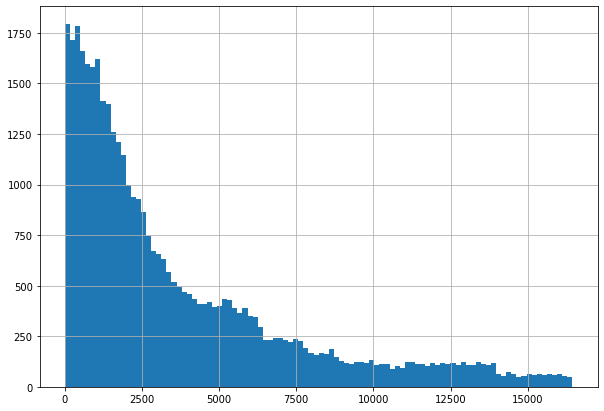

In [76]:
plt.rcParams['figure.figsize'] = (10,7)
df_train['Ranking'].hist(bins=100)

У нас много ресторанов, которые не дотягивают и до 2500 места в своем городе, а что там по городам?

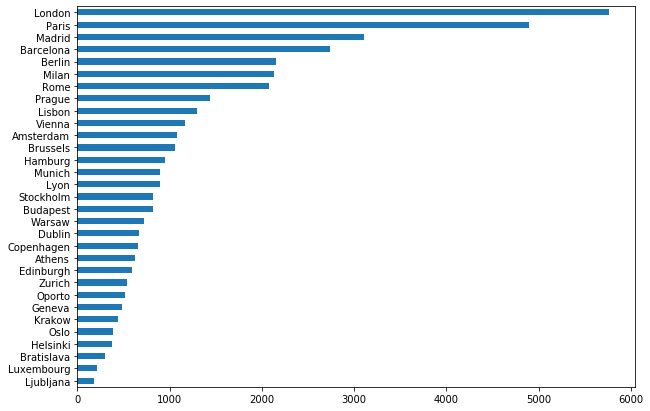

In [77]:
df_train['City'].value_counts(ascending=True).plot(kind='barh')

А кто-то говорил, что французы любят поесть=) Посмотрим, как изменится распределение в большом городе:

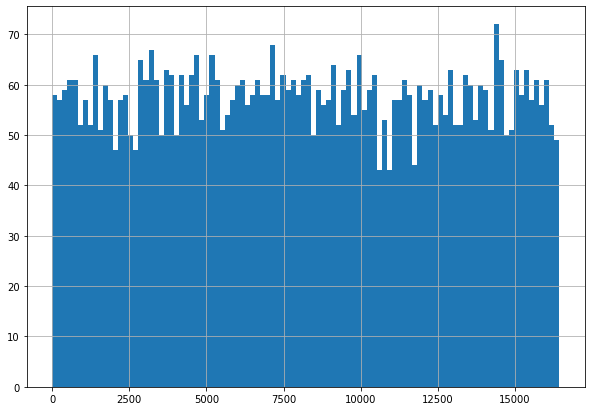

In [78]:
df_train['Ranking'][df_train['City'] =='London'].hist(bins=100)

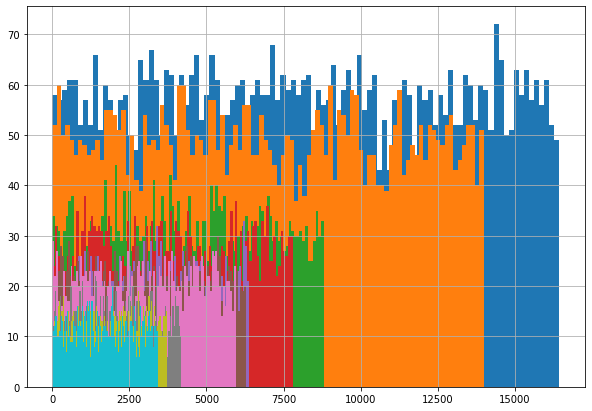

In [79]:
# посмотрим на топ 10 городов
for x in (df_train['City'].value_counts())[0:10].index:
    df_train['Ranking'][df_train['City'] == x].hist(bins=100)
plt.show()

Получается, что Ranking имеет нормальное распределение, просто в больших городах больше ресторанов, из-за мы этого имеем смещение.

>Подумайте как из этого можно сделать признак для вашей модели. Я покажу вам пример, как визуализация помогает находить взаимосвязи. А далее действуйте без подсказок =) 


### Посмотрим распределение целевой переменной

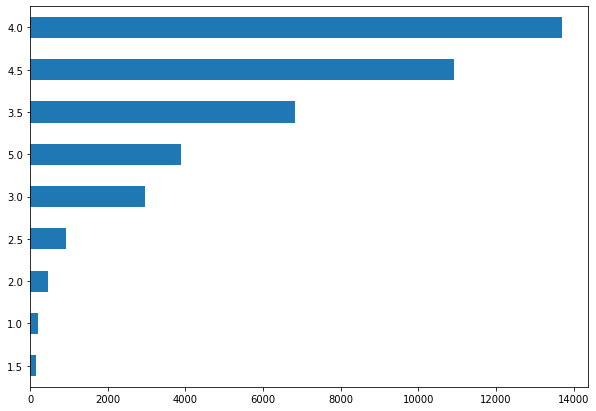

In [80]:
df_train['Rating'].value_counts(ascending=True).plot(kind='barh')

### Посмотрим распределение целевой переменной относительно признака

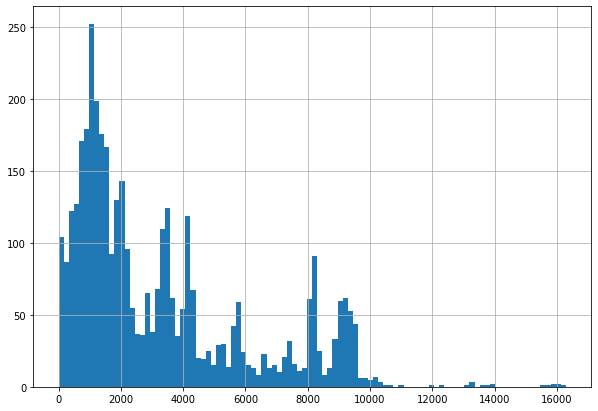

In [81]:
df_train['Ranking'][df_train['Rating'] == 5].hist(bins=100)

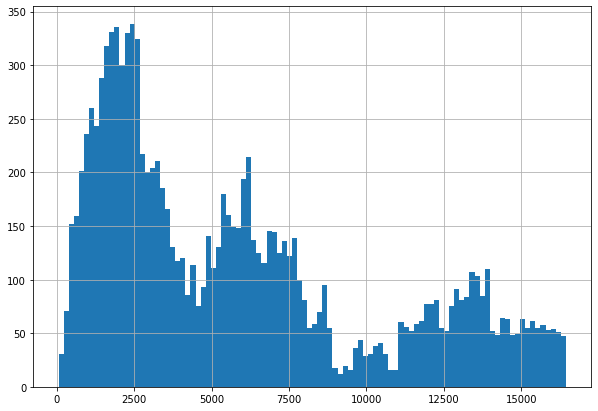

In [82]:
df_train['Ranking'][df_train['Rating'] < 4].hist(bins=100)

### И один из моих любимых - [корреляция признаков](https://ru.wikipedia.org/wiki/Корреляция)
На этом графике уже сейчас вы сможете заметить, как признаки связаны между собой и с целевой переменной.

In [83]:
plt.rcParams['figure.figsize'] = (15,10)
#sns.heatmap(data.drop(['sample'], axis=1).corr(),)

Вообще благодаря визуализации в этом датасете можно узнать много интересных фактов, например:
* где больше Пицерий в Мадриде или Лондоне?
* в каком городе кухня ресторанов более разнообразна?

придумайте свои вопрос и найдите на него ответ в данных)

# Data Preprocessing

#### Запускаем и проверяем что получилось

In [85]:
#df_preproc = preproc_data(data)
#df_preproc.sample(10)

In [86]:
#df_preproc.info()

In [87]:
# Теперь выделим тестовую часть

data = pd.concat([data, cuisine_pd, word_features], axis=1)

train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

y = train_data.Rating.values            # наш таргет
X = train_data.drop(['Rating'], axis=1)

**Перед тем как отправлять наши данные на обучение, разделим данные на еще один тест и трейн, для валидации. 
Это поможет нам проверить, как хорошо наша модель работает, до отправки submissiona на kaggle.**

In [88]:
X = X.drop(X.select_dtypes(include=['object']).columns, axis=1)
X = X.drop(X.select_dtypes(include=['datetime']).columns, axis=1)


In [89]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [90]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((10000, 754), (40000, 754), (40000, 740), (32000, 740), (8000, 740))

# Model 
Сам ML

In [91]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [92]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [93]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   29.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.2min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [94]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
y_pred_tt = y_pred

# Небольшая компенсация ошибки
alpha = 0.02
y_pred_tt = y_pred_tt - alpha
print('MAE:', metrics.mean_absolute_error(y_test, norm_rank(y_pred_tt)))

MAE: 0.1569375


In [95]:
X.head()

,Ranking,Price Range,Number of Reviews,Number_of_Reviews_isNAN,City_Amsterdam,City_Athens,City_Barcelona,City_Berlin,City_Bratislava,City_Brussels,...,work,world,worst,worth,would,wow,year,yet,yum,yummy
10000,5570.0,100,194.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10001,1537.0,100,10.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10002,353.0,150,688.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10003,3458.0,100,3.0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
10004,621.0,100,84.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


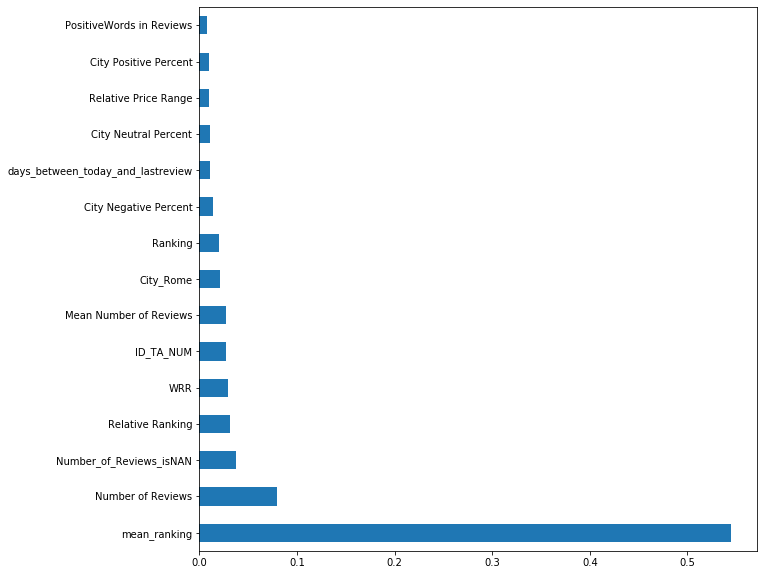

In [96]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

# Submission
Если все устраевает - готовим Submission на кагл

In [97]:
test_data.sample(10)

,Restaurant_id,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,Rating,Number_of_Reviews_isNAN,...,work,world,worst,worth,would,wow,year,yet,yum,yummy
2652,id_2652,"[Chinese, Japanese]",4213.0,50,23.0,"[['OK Oriental lunch break', 'Great and fast a...",/Restaurant_Review-g187849-d7996895-Reviews-Ch...,d7996895,0.0,0,...,0,0,0,0,0,0,0,0,0,0
6037,id_6037,[Local],2393.0,100,4.0,"[['Great for breakfast'], ['03/02/2017']]",/Restaurant_Review-g188644-d8040964-Reviews-Fr...,d8040964,0.0,0,...,0,0,0,0,0,0,0,0,0,0
4274,id_4274,[Local],10215.0,100,3.0,[['Opened till 10 pm a few meter of Place de.....,/Restaurant_Review-g187147-d10619213-Reviews-B...,d10619213,0.0,0,...,0,0,0,0,0,0,0,0,0,0
3670,id_3670,"[Diner, Wine Bar]",8850.0,100,59.0,"[['Honest food for reasonable price', 'How sim...",/Restaurant_Review-g187147-d4971558-Reviews-Pi...,d4971558,0.0,0,...,0,0,0,0,0,0,0,0,0,0
6686,id_6686,"[Indian, Asian, Vegetarian Friendly, Vegan Opt...",1950.0,50,79.0,"[['Good value Indian food', 'Small, but great ...",/Restaurant_Review-g187323-d954338-Reviews-Ash...,d954338,0.0,0,...,0,0,0,0,0,0,0,0,0,0
2626,id_2626,"[French, European, International]",4923.0,100,129.0,[['Pleasant atmosphere away from the madness.....,/Restaurant_Review-g187147-d7264289-Reviews-Ch...,d7264289,0.0,0,...,0,0,0,0,0,0,0,0,0,0
2399,id_2399,"[European, Eastern European, Central European,...",47.0,100,752.0,"[['Delicious food and wine', 'Wonderful Hungar...",/Restaurant_Review-g274887-d692912-Reviews-Ros...,d692912,0.0,0,...,0,0,0,0,0,0,0,0,0,0
4620,id_4620,"[Mexican, Fast Food, Latin, Spanish, South Ame...",302.0,100,10.0,"[['Great burritos', 'Big tasty burrito'], ['02...",/Restaurant_Review-g274873-d6475520-Reviews-Bu...,d6475520,0.0,0,...,0,0,0,0,0,0,0,0,0,0
7970,id_7970,"[Cafe, Fast Food, Spanish, Vegetarian Friendly]",1662.0,50,253.0,"[['Lunch sandwich', 'Economic and good'], ['12...",/Restaurant_Review-g187514-d4698913-Reviews-Ro...,d4698913,0.0,0,...,0,0,0,0,0,0,0,0,0,0
108,id_108,"[Japanese, Sushi, Chinese, Vegetarian Friendly]",490.0,100,63.0,"[['Fun', 'The fry is the best'], ['04/10/2017'...",/Restaurant_Review-g187331-d2554554-Reviews-4m...,d2554554,0.0,0,...,0,0,0,0,0,0,0,0,0,0


In [98]:
test_data = test_data.drop(['Rating'], axis=1)

In [99]:
sample_submission

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0
5,id_5,4.5
6,id_6,4.5
7,id_7,2.0
8,id_8,2.0
9,id_9,3.5


In [100]:
test_data = test_data.drop(test_data.select_dtypes(include=['object']).columns, axis=1)
test_data = test_data.drop(test_data.select_dtypes(include=['datetime']).columns, axis=1)
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished


In [101]:
# Приведем значения предсказаний к правильному виду

# Небольшая компенсация ошибки
alpha = 0.02

predict_submission = norm_rank(predict_submission - alpha)
predict_submission

array([3. , 4.5, 4.5, ..., 3. , 4.5, 4.5])

In [102]:
predict_submission

array([3. , 4.5, 4.5, ..., 3. , 4.5, 4.5])

In [103]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,Restaurant_id,Rating
0,id_0,3.0
1,id_1,4.5
2,id_2,4.5
3,id_3,4.5
4,id_4,4.5
5,id_5,4.5
6,id_6,1.5
7,id_7,3.5
8,id_8,4.0
9,id_9,4.5


# What's next?
Или что делать, чтоб улучшить результат:
* Обработать оставшиеся признаки в понятный для машины формат
* Посмотреть, что еще можно извлечь из признаков
* Сгенерировать новые признаки
* Подгрузить дополнительные данные, например: по населению или благосостоянию городов
* Подобрать состав признаков

В общем, процесс творческий и весьма увлекательный! Удачи в соревновании!
